# CancerNet - A deep learning approach to predict & classify Cancers.

## 1. Obtaining the data<br>
- The dataset used in the following project is obtained at the following link<br>
> data link: [Multi Cancer dataset](https://www.kaggle.com/datasets/obulisainaren/multi-cancer/data) <br>
> credits: [Obuli Sai Naren](https://www.kaggle.com/obulisainaren)

**Data Card**<br>
- The given dataset contains various kinds of images per type of cancers. <br>
- Details of the dataset are as below ⇓ <br>
 **Cancer	                  Classes	   Images** : <br>

Acute Lymphoblastic Leukemia	4	      20000 <br>
Brain Cancer	                3	      15000 <br>
Breast Cancer	                2	      10000 <br>
Cervical Cancer	              5	      25000 <br>
Kidney Cancer	                2	      10000 <br>
Lung and Colon Cancer	        5	      25000 <br>
Lymphoma	                    3	      15000 <br>
Oral Cancer	                  2	      10000 <br>

*Each Sub-Class contains 5000 Images*<br>

---

> - main classes = 8<br>
> - Sub-classes  = 26<br>
> - Format   = JPEG <br>
> - Dimensions  = 512x512px




### Setting up kaggle Environment:

In [1]:
#from google.colab import files
#files.upload()

In [2]:
#setting up directory
"""!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json"""

'!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle\n!chmod 600 ~/.kaggle/kaggle.json'

In [3]:
#Setting up fastkaggle:
!pip install --q opendatasets

In [4]:
import opendatasets as od
data_url = "https://www.kaggle.com/datasets/obulisainaren/multi-cancer/data"
od.download(data_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  paradoxicalvariable


Your Kaggle Key:

  ································


Dataset URL: https://www.kaggle.com/datasets/obulisainaren/multi-cancer


100%|██████████| 8.62G/8.62G [04:43<00:00, 32.7MB/s]  


In [5]:
#downloading & setting up required libraries
!pip install --q fastcore>=1.4.5
!pip install --q fastai>=2.7.1
!pip install --q timm>=0.6.2.dev0

In [6]:
import timm
from fastai.vision.all import *
from pathlib import Path

set_seed(2000)

#If environment is kaggle
data_path = Path("/kaggle/working/multi-cancer/Multi Cancer")

#### Setting up dataset:

In [7]:
data_path.ls()

(#8) [Path('/kaggle/working/multi-cancer/Multi Cancer/Lymphoma'),Path('/kaggle/working/multi-cancer/Multi Cancer/Oral Cancer'),Path('/kaggle/working/multi-cancer/Multi Cancer/Cervical Cancer'),Path('/kaggle/working/multi-cancer/Multi Cancer/Lung and Colon Cancer'),Path('/kaggle/working/multi-cancer/Multi Cancer/Kidney Cancer'),Path('/kaggle/working/multi-cancer/Multi Cancer/Brain Cancer'),Path('/kaggle/working/multi-cancer/Multi Cancer/ALL'),Path('/kaggle/working/multi-cancer/Multi Cancer/Breast Cancer')]

In [8]:
input_files = get_image_files(data_path)

In [9]:
len(input_files)

130002

(512, 512)


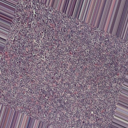

In [10]:
example = PILImage.create(input_files[0])
print(example.size)
example.to_thumb(128)

*note*: <br>
- The data has been loaded successfully and can render example images.

## 2. Data-Preprocessing:

In [11]:
#Loading the sizes of input images
from fastcore.parallel import *

def show_imgsize(input_image):
  return PILImage.create(input_image).size

sizes = parallel(show_imgsize, input_files, n_workers=6)
pd.Series(sizes).value_counts()

(512, 512)    129999
(640, 640)         3
Name: count, dtype: int64

**Notes about image sizes**:<br>
- 512 x 512px == 1,29,999 <br>
- 640 x 640px == 3

### a. Creating DataLoaders:

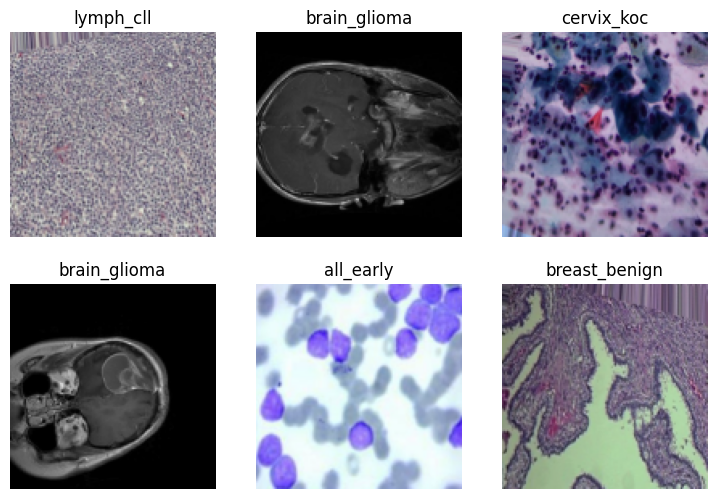

In [12]:
image_dls = ImageDataLoaders.from_folder(
    path=data_path,
    valid_pct=0.2,
    seed=150,
    item_tfms=Resize(512, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
)

#An example batch of images
image_dls.show_batch(max_n=6)

### b. Creating a base model:

- Creating a base model to check how image models are performing <br>
> `convnext_tiny_in22k`

- since the dataset size is very large(~9.00GB) and the models used are of larger size, Implementing Gradient Accumulation to save GPU memory.

In [13]:
def train(architecture, items, batch, epochs=1, accum=2, finetune=True):

  #Creating a dataloader with accumulator:
  dataloader = ImageDataLoaders.from_folder(
      path=data_path,
      valid_pct=0.20,
      seed=150,
      item_tfms=items,
      batch_tfms=batch,
      bs=64//accum
  )

  #Enabling Gradient-Accumulation:
  callbacks = GradientAccumulation(64) if accum else []

  #Creating learner:
  learner = vision_learner(
      dls=dataloader,
      arch=architecture,
      metrics=error_rate,
      cbs=callbacks
  ).to_fp16()

  #Finetuning if it is needed:
  if finetune:
    learner.fine_tune(epochs, base_lr=0.001)

  else:
    learner.unfreeze()
    learner.fit_one_cycle(epochs,  lr_max=0.001)


In [14]:
#Training a base model:
#arch = "convnext_tiny_in22k"
#items = Resize(192)
#epochs = 1

#train(architecture=arch, 
      #items=items, 
      #batch=aug_transforms(size=128, min_scale=0.70), 
      #epochs=epochs, 
      #accum=2, 
      #finetune=False)

- Checking for memory usage in the models:

In [15]:
!pip install --q pynvml

In [16]:
import gc
def measure_train_time():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [17]:
measure_train_time()

GPU:0
process       2352 uses     1100.000 MB GPU memory


---

---

## Training multiple image models & ensembling results to produce higher accuracy:

**Since our dataset is quite large(containing somewhat 1.3L images), resizing these images into smaller resolutions**

#### Processes: <br>
- Since our dataset is quite large, relying on a single model may not produce high quality results.<br>
- We aim to train 4 to 5 different image models and ensemble their results into one whole(how a random forest works)<br>
- We also aim to apply test-time augmentation to further make our models predict better.

In [18]:
resize_images(data_path, dest=data_path, max_size=224, recurse=True)

In [19]:
#Measuring the sizes of images after resizing:
input_files = get_image_files(data_path)
sizes = parallel(show_imgsize, input_files, n_workers=5)

In [20]:
pd.Series(sizes).value_counts()

(224, 224)    130002
Name: count, dtype: int64

In [24]:
#Redefining the training function:
def train(architecture, items, batch, epochs=1, accum=2, finetune=True, lr=0.01):

  #Creating a dataloader with accumulator:
  dataloader = ImageDataLoaders.from_folder(
      path=data_path,
      valid_pct=0.20,
      seed=150,
      item_tfms=items,
      batch_tfms=batch,
      bs=64//accum
  )

  #Enabling Gradient-Accumulation:
  callbacks = GradientAccumulation(64) if accum else []

  #Creating learner:
  learner = vision_learner(
      dls=dataloader,
      arch=architecture,
      metrics=error_rate,
      cbs=callbacks
  ).to_fp16()

  #Finetuning if it is needed:
  if finetune:
    learner.fine_tune(epochs, base_lr=lr)

  else:
    learner.unfreeze()
    learner.fit_one_cycle(epochs,  lr)
  
  return learner

#### Creating an ensemble of following 4 models and fine-tuning each of them:<br>
- `regnetx_016`<br>
- `resnet26d`<br>
- `vit_small_patch16_224`<br>
- `vit_small_patch32_224`

In [25]:
#Creating base parameters:
items = Resize((224, 224), method="squish")
epochs = 3
accum = 2
finetune = True
lr = 0.01
results = []

**A. Regnetx-016 model:**

In [26]:
"""arch = "regnetx_016"

print("______________________________________________________________________________", end='\n')
print(f"{arch} fine-tuning started!...")

regnet = train(architecture=arch,
              items=items,
              batch=aug_transforms(size=224, min_scale=0.6),
              epochs=epochs,
              accum=accum,
              finetune=finetune,
              lr=lr)

print(f"{arch} model is fine-tuned, now saving the model...")
regnet.export('regnetx_016.pkl')

print(f"GPU Memory Usage Report: {measure_train_time()}")

results.append(regnet)
gc.collect()
torch.cuda.empty_cache()"""

______________________________________________________________________________
regnetx_016 fine-tuning started!...


epoch,train_loss,valid_loss,error_rate,time
0,0.424023,0.343404,0.136423,11:37


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

**B. ResNet_26d model:**

In [ ]:
"""arch = "resnet26d"
print("______________________________________________________________________________", end='\n')
print(f"{arch} fine-tuning started!...")

resnet = train(architecture=arch,
              items=items,
              batch=aug_transforms(size=224, min_scale=0.6),
              epochs=epochs,
              accum=accum,
              finetune=finetune,
              lr=lr)

print(f"{arch} model is fine-tuned, now saving the model...")
resnet.export('resnet26.pkl')

print(f"GPU Memory Usage Report: {measure_train_time()}")

results.append(resnet)
gc.collect()
torch.cuda.empty_cache()"""

**C. ViT_small_patch16_224 model:**

In [27]:
arch = "vit_small_patch16_224"
print("______________________________________________________________________________", end='\n')
print(f"{arch} fine-tuning started!...")

vit_patch16 = train(architecture=arch,
              items=items,
              batch=aug_transforms(size=224, min_scale=0.6),
              epochs=epochs,
              accum=accum,
              finetune=finetune,
              lr=lr)

print(f"{arch} model is fine-tuned, now saving the model...")
vit_patch16.export('vit_patch16_small.pkl')

print(f"GPU Memory Usage Report: {measure_train_time()}")

results.append(vit_patch16)
gc.collect()
torch.cuda.empty_cache()

______________________________________________________________________________
vit_small_patch16_224 fine-tuning started!...


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.351842,0.170587,0.068654,09:37


epoch,train_loss,valid_loss,error_rate,time
0,0.110843,0.059475,0.021154,12:21
1,0.033605,0.011599,0.004269,12:19
2,0.007381,0.006422,0.002192,12:20


vit_small_patch16_224 model is fine-tuned, now saving the model...
GPU:0
process       2352 uses     2126.000 MB GPU memory
GPU Memory Usage Report: None


In [28]:
arch = "vit_small_patch32_224"
print("___________________________________________________________________", end='\n')
print(f"Fine-Tuning model: {arch}")

vit_patch32 = train(architecture=arch,
                   items=items,
                   batch=aug_transforms(size=224, min_scale=0.6),
                   epochs=epochs,
                   accum=accum,
                   finetune=finetune,
                   lr=lr)
print(f"{arch} successfully fine-tuned, saving model...")
vit_patch32.export('vit_patch32_small.pkl')

print(f"GPU Memory Usage Report: {measure_train_time()}")

results.append(vit_patch32)
gc.collect()
torch.cuda.empty_cache()



___________________________________________________________________
Fine-Tuning model: vit_small_patch32_224


model.safetensors:   0%|          | 0.00/91.5M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.334081,0.207075,0.080346,04:28


epoch,train_loss,valid_loss,error_rate,time
0,0.118348,0.157386,0.053000,05:24
1,0.045428,0.028193,0.010115,05:22
2,0.015743,0.012022,0.004846,05:22


vit_small_patch32_224 successfully fine-tuned, saving model...
GPU:0
process       2352 uses     1640.000 MB GPU memory
GPU Memory Usage Report: None


## Some footers & Notes about the notebook:<br>
- The training time per epoch was reduced from approx 1.05 hours to approx 15 minutes.<br>
- We were able to save huge amounts of GPU memory by implementing Gradient accumulation.<br>
- Ensembling of models was cut short from using 4 models to 2 models since ViT gave an overall faster training time and decent accuracy.<br>
- Future updates will include training larger and better models with full input_size.